In [13]:
__author__ = "Thaiph99"

# Check require packages version

In [14]:
# from mmcv import collect_env
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
import mmdet
import mmrotate
from mmrotate.utils import collect_env

collect_env()

# Check MMRotate installation
print(mmrotate.__version__)

# Check MMDetection installation
print(mmdet.__version__)

# Check mmcv installation
print(get_compiling_cuda_version())
print(get_compiler_version())

1.0.0rc1
3.1.0
10.2
GCC 7.3


In [15]:
!mim list
!echo '----------'
!pip list | grep ^mm

Package    Version    Source
---------  ---------  -----------------------------------------
mmcv       2.0.1      https://github.com/open-mmlab/mmcv
mmdet      3.1.0      https://github.com/open-mmlab/mmdetection
mmengine   0.8.3      https://github.com/open-mmlab/mmengine
mmrotate   1.0.0rc1   /home/thaipham/horus/mmrotate
----------
mmcv                          2.0.1
mmdet                         3.1.0
mmengine                      0.8.3
mmrotate                      1.0.0rc1  /home/thaipham/horus/mmrotate


# Build model

In [16]:
from mmdet.registry import VISUALIZERS
import mmcv
from mmengine.runner import load_checkpoint

from mmdet.apis import inference_detector, init_detector
# from mmdet.apis.inference import show_result_pyplot
# from mmrotate.models import build_detector

# Choose to use a config and initialize the detector
# config = 'oriented_rcnn_r50_fpn_1x_dota_le90.py'
config = "../configs/rotated_rtmdet/rotated_rtmdet_l-3x-dota_ms_custom_v2.py"
# Setup a checkpoint file to load
# checkpoint = 'oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth'
checkpoint = "../rotated_rtmdet_l_3x_v1/epoch_36.pth"

# Set the device to be used for evaluation
device = 'cuda:0'

model = init_detector(config, checkpoint, device)


Loads checkpoint by local backend from path: ../rotated_rtmdet_l_3x_v1/epoch_36.pth


# Model inference & visualize

In [17]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [18]:
image_path = "../../data/oriented_bbox_labels/images1/images/1.jpg"
image = mmcv.imread(image_path)

result = inference_detector(model, image)

In [19]:
font_face = cv2.FONT_HERSHEY_SIMPLEX
font_scale = 0.7
font_thickness = 2
font_color = (255, 255, 255)
text_offset = np.array([0, -10]).reshape((1, 1, -1)).astype(np.int32)

In [20]:
# initialize tracker
!pip install similari-trackers-rs


from similari import Universal2DBox, Sort, SpatioTemporalConstraints, PositionalMetricType, BoundingBox
constraints = SpatioTemporalConstraints()
constraints.add_constraints([(1, 1.0)])

iou_metric = PositionalMetricType.iou(threshold=0.09)
maha_metric = PositionalMetricType.maha()

tracker = Sort(
    shards=4,
    bbox_history=2*5,
    max_idle_epochs=5,
    method=iou_metric,
    spatio_temporal_constraints=constraints,
)

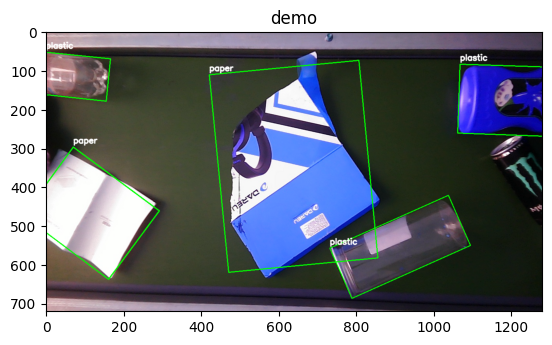

In [21]:

bboxes = result.pred_instances.bboxes.cpu().numpy()
pred_scores = result.pred_instances.scores.cpu().numpy()
labels = result.pred_instances.labels.cpu().numpy()
labels_name = ("paper", "metal", "plastic", "nilon", "glass", "fabric")

confidence_threshold = 0.7
pi = 22/7
img = cv2.imread(image_path)
filtered_indices = np.where(pred_scores > confidence_threshold)[0]
filtered_bboxes = bboxes[filtered_indices]


for idx in filtered_indices:
    bbox = bboxes[idx]

    # draw bbox
    xc, yc, width, height, radian = bbox
    degrees = radian * (180/pi)
    points = cv2.boxPoints(((xc, yc), (width, height), degrees))
    pts = np.array(points).reshape((1, -1, 1, 2)).astype(np.int32)

    cv2.polylines(img, pts, True, (0, 255, 0), 2)

    # draw class
    label = labels_name[labels[idx]]
    text_size, baseline = cv2.getTextSize(
        label, font_face, font_scale, font_thickness
    )
    point_text_orig = pts[0, 1, :] + text_offset

    rect_tl = point_text_orig + np.array([0, baseline]).reshape(
        (1, 1, -1)
    ).astype(np.int32)

    rect_br = point_text_orig + np.array(
        [text_size[1], -text_size[1]]
    ).reshape((1, 1, -1)).astype(np.int32)


    img = cv2.putText(
        img,
        label,
        point_text_orig.ravel(),
        font_face,
        font_scale,
        font_color,
        font_thickness,
        cv2.LINE_AA,
    )


    # plt.imshow(img)
    # plt.title('demo')
    # plt.show()

plt.imshow(img)
plt.title('demo')
plt.show()
# cv2.imshow("test", img)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [22]:
tracker.skip_epochs(10)
wasted = tracker.wasted()

# or just clear wasted
tracker.clear_wasted()

In [23]:
import time

cap = cv2.VideoCapture('/home/thaipham/Videos/output2.avi')
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))
size = (frame_width, frame_height)
fps = int(cap.get(cv2.CAP_PROP_FPS))
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
res_video = cv2.VideoWriter('./output.mp4',
                            fourcc,
                            9,
                            size)

prev_frame_time, new_frame_time = 0, 0

if (cap.isOpened() == False):
    print("Error opening video file")

while (cap.isOpened()):

    ret, frame = cap.read()
    if ret == False:
        break
    # Display the resulting frame
    result = inference_detector(model, frame)

    bboxes = result.pred_instances.bboxes.cpu().numpy()
    pred_scores = result.pred_instances.scores.cpu().numpy()
    labels = result.pred_instances.labels.cpu().numpy()
    labels_name = ("paper", "metal", "plastic", "nilon", "glass", "fabric")

    confidence_threshold = 0.55
    pi = 22/7
    filtered_indices = np.where(pred_scores > confidence_threshold)[0]
    filtered_bboxes = bboxes[filtered_indices]

    frame_detections = []

    new_frame_time = time.time()
    fps = 1/(new_frame_time-prev_frame_time)
    fps_str = "fps: {}".format(int(fps))
    prev_frame_time = new_frame_time

    cv2.putText(frame, fps_str, (7, 700), cv2.FONT_HERSHEY_SIMPLEX, 2, (100, 0, 255), 3, cv2.LINE_4)

    for idx in filtered_indices:
        bbox = bboxes[idx]
        xc, yc, width, height, radian = bbox

        # with rotated bounding box
        frame_detections.append((
            Universal2DBox.new_with_confidence(
                xc=xc,
                yc=yc,
                angle=1.5708,
                aspect=width/height,
                height=height,
                confidence=1
            ),
            None
        ))

    res = tracker.predict(frame_detections)

    for i, idx in enumerate(filtered_indices):
        bbox = bboxes[idx]

        # draw bbox
        xc, yc, width, height, radian = bbox
        degrees = radian * (180/pi)
        points = cv2.boxPoints(((xc, yc), (width, height), degrees))
        pts = np.array(points).reshape((1, -1, 1, 2)).astype(np.int32)

        cv2.polylines(frame, pts, True, (0, 255, 0), 2)

        # draw class
        label = labels_name[labels[idx]]
        text_size, baseline = cv2.getTextSize(
            label, font_face, font_scale, font_thickness
        )
        point_text_orig = pts[0, 1, :] + text_offset

        rect_tl = point_text_orig + np.array([0, baseline]).reshape(
            (1, 1, -1)
        ).astype(np.int32)

        rect_br = point_text_orig + np.array(
            [text_size[1], -text_size[1]]
        ).reshape((1, 1, -1)).astype(np.int32)

        frame = cv2.putText(
            frame,
            label,
            point_text_orig.ravel(),
            font_face,
            font_scale,
            font_color,
            font_thickness,
            cv2.LINE_8,
        )

        # draw object id
        obj = res[i]

        obj_id = obj.id

        text = f"#{obj_id}"

        text_size, baseline = cv2.getTextSize(
            text, font_face, font_scale, font_thickness
        )
        point_text_orig = pts[0, 0, :] + text_offset

        rect_tl = point_text_orig + np.array([0, baseline]).reshape(
            (1, 1, -1)
        ).astype(np.int32)

        rect_br = point_text_orig + np.array(
            [text_size[1], -text_size[1]]
        ).reshape((1, 1, -1)).astype(np.int32)

        frame = cv2.putText(
            frame,
            text,
            point_text_orig.ravel(),
            font_face,
            font_scale,
            (0, 200, 255),
            font_thickness,
            cv2.LINE_4,
        )

        # draw tracker bounding box
        # if obj.predicted_bbox.angle != None:
        #     degrees = int(obj.predicted_bbox.angle * (180/(22/7)))
        # else:
        #     degrees = obj.predicted_bbox.angle

        # xc = obj.predicted_bbox.xc
        # yc = obj.predicted_bbox.yc
        # height = obj.predicted_bbox.height
        # width = height * obj.predicted_bbox.aspect

        # points_track = cv2.boxPoints(((xc, yc), (width, height), degrees))
        # pts_track = np.array(points_track).reshape((1, -1, 1, 2)).astype(np.int32)
        # cv2.polylines(frame, pts_track, True, (0, 255, 0), 2)

    res_video.write(frame)
    ims = cv2.resize(frame, size)
    cv2.imshow('Frame', ims)

    # Press Q on keyboard to exit
    if cv2.waitKey(25) & 0xFF == ord('q'):
        break

cap.release()
res_video.release()

# Closes all the frames
cv2.destroyAllWindows()
# print("The video was successfully saved")

In [24]:
print("final id: ", text)

final id:  #167
